# Diversity of Ideas: Stanford Daily


## Setup

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
import pandas as pd
from util.ouraws import (
    getFromFile
)

In [3]:
%pwd

'c:\\Users\\theod\\dev\\diversity-ideas\\notebooks\\2024'

In [4]:
df = getFromFile("../../data/stanford-opinions.parquet", False)
df.shape


(5121, 6)

In [5]:
df.head(4)

,title,url,body,year,month,day
0,Student activism is the antidote to Silicon Va...,https://stanforddaily.com/2024/11/20/student-a...,Student activism is the antidote to Silicon Va...,2024,11,1
1,Social media is replacing our politicians with...,https://stanforddaily.com/2024/12/05/social-me...,Social media is replacing our politicians with...,2024,12,1
2,From the Community | Should Stanford offer a b...,https://stanforddaily.com/2024/12/01/stanford-...,From the Community | Should Stanford offer a b...,2024,12,1
3,Letter to the Editor | Maria Corina Machado sh...,https://stanforddaily.com/2024/11/25/letter-to...,Letter to the Editor | Maria Corina Machado sh...,2024,11,1


## Function Definitions

In [6]:
import numpy as np
import re

In [24]:
def getCovDispersion(wv):
    """
    Calculate various dispersion measures using the covariance matrix of word vectors.
    
    Args:
        wv: numpy array of shape (n_documents, embedding_dim) containing document embeddings
        
    Returns:
        tuple containing:
        - N: number of documents
        - trace_norm: average variance along the diagonal
        - l1_norm: L1 norm of covariance matrix (normalized)
        - l2_norm: L2 norm of covariance matrix (normalized)
        - inf_norm: Infinity norm of covariance matrix (normalized)
    """
    # Get number of documents
    N = len(wv)
    
    # Calculate covariance matrix of the word vectors
    # This measures how dimensions vary together across documents
    cov = np.cov(wv)
    
    return (
        N,  # Number of documents
        np.trace(cov)/N,  # Average variance along diagonal (spread in each dimension)
        np.linalg.norm(cov, ord=1)/N,  # L1 norm (sum of absolute values)
        np.linalg.norm(cov, ord=2)/N,  # L2/Spectral norm (largest singular value)
        np.linalg.norm(cov, ord=np.inf)/N,  # Infinity norm (max absolute row sum)
    )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [8]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [9]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [11]:
diversity_pattern = "|".join(diversity_lemmas)

Let's verify how the "count" of diversity words in the text is calculated.

In [12]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

## Analysis

In [13]:
from openai import OpenAI
from typing import List
import numpy as np
client = OpenAI()

In [14]:
def get_embedding(text: str) -> List[float]:
    """
    Get embeddings for a single text using text-embedding-3-large model.
    
    Args:
        text (str): The input text to generate embeddings for
        
    Returns:
        List[float]: The embedding vector
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
        dimensions=1024  # Optional: You can specify 256, 512, or 1024 dimensions
    )
    return response.data[0].embedding

def get_batch_embeddings(texts: List[str]) -> List[List[float]]:
    """
    Get embeddings for multiple texts in a single API call.
    
    Args:
        texts (List[str]): List of input texts to generate embeddings for
        
    Returns:
        List[List[float]]: List of embedding vectors
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=texts,
        dimensions=1024
    )
    return [item.embedding for item in response.data]

In [15]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    # Step 1: Clean and normalize each text in the series
    # - Convert to lowercase
    # - Lemmatize each word (convert to base form)
    # - Remove stopwords
    # - Join words back together with spaces
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    
    # Step 2: Filter out short texts
    # Remove any text less than 100 characters as they're likely too short for meaningful analysis
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    
    # Step 3: Remove any null values created by the previous step
    text_series = text_series.dropna()
    
    # Step 4: Count diversity-related terms
    # Sum up all instances of diversity-related words (defined in diversity_pattern)
    # across all remaining texts in the series
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    
    # Return both the cleaned text series and the total count of diversity words
    return text_series, total_diversity_words

In [17]:
START_YEAR = 2009
FINAL_YEAR = 2024

In [18]:
year_2024 = df[df.year==2024]
clean_df, num_diversity_words = prepText(year_2024.body)
wv = get_batch_embeddings(clean_df)

In [19]:
type(wv[0])

list

In [20]:
docmatrix = np.array(wv)

In [21]:
docmatrix.shape

(76, 1024)

In [22]:
pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
cov = getCovDispersion(docmatrix)
print(f"{year_2024.year}, {cov[0]}, {cov[1]}, {pairwise}")

0     2024
1     2024
2     2024
3     2024
4     2024
      ... 
87    2024
88    2024
89    2024
90    2024
92    2024
Name: year, Length: 92, dtype: int64, 76, 0.0009768024549865824, 0.6100499331721485


In [23]:
pairwise

np.float64(0.6100499331721485)

In [25]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = get_batch_embeddings(clean_df)
    
    docmatrix = np.array(wv)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2009, 3, 0.0009770580534923354, 0.7152663161505542
2010, 207, 0.0009766161963553665, 0.7101992512292903
2011, 137, 0.0009764374886683648, 0.6915979523999602
2012, 50, 0.0009765076608169664, 0.7342186828184183
2013, 32, 0.0009767194839347436, 0.7290125446162634
2014, 62, 0.0009762635088361256, 0.7515590268621716
2015, 68, 0.0009765504985679129, 0.785611806261693
2016, 44, 0.0009768164858024815, 0.7256717605860117
2017, 66, 0.000976626065155388, 0.7204340188821687
2018, 55, 0.0009765965570699264, 0.7138031023841415
2019, 101, 0.0009766771171091176, 0.6856330786001004
2020, 166, 0.0009769097599820573, 0.6675473598979964
2021, 116, 0.0009768050667808613, 0.6288715570308244
2022, 91, 0.0009766632286124515, 0.6207662847780695
2023, 84, 0.0009768756679156775, 0.5746250756487502
2024, 76, 0.00097679855438417, 0.6101526788683128


In [27]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2009,0.715266,3,0.000977,0.000538,0.000513,0.000538,0,0.000000
2010,0.710199,207,0.000977,0.000372,0.000290,0.000372,2,0.009662
2011,0.691598,137,0.000976,0.000412,0.000311,0.000412,4,0.029197
2012,0.734219,50,0.000977,0.000372,0.000283,0.000372,0,0.000000
2013,0.729013,32,0.000977,0.000355,0.000297,0.000355,2,0.062500
2014,0.751559,62,0.000976,0.000332,0.000261,0.000332,4,0.064516
2015,0.785612,68,0.000977,0.000289,0.000226,0.000289,0,0.000000
2016,0.725672,44,0.000977,0.000388,0.000297,0.000388,4,0.090909
2017,0.720434,66,0.000977,0.000388,0.000300,0.000388,4,0.060606


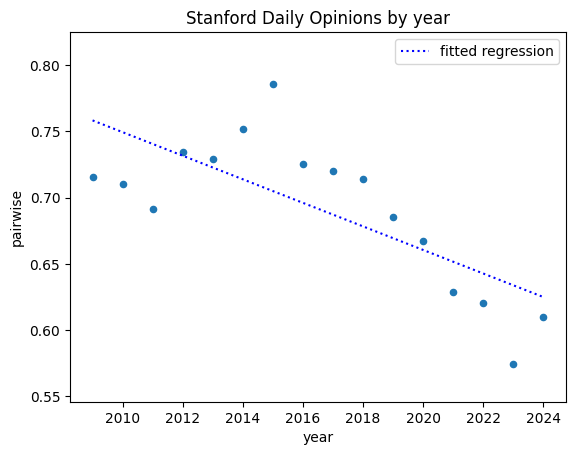

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Stanford Daily Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.00168, int:0.02862, r:0.19620, p:0.48342, se:0.00232, x:range(0, 15)
pairwise slope:-0.01012, int:0.76079, r:-0.77043, p:0.00078, se:0.00232, x:range(0, 15)


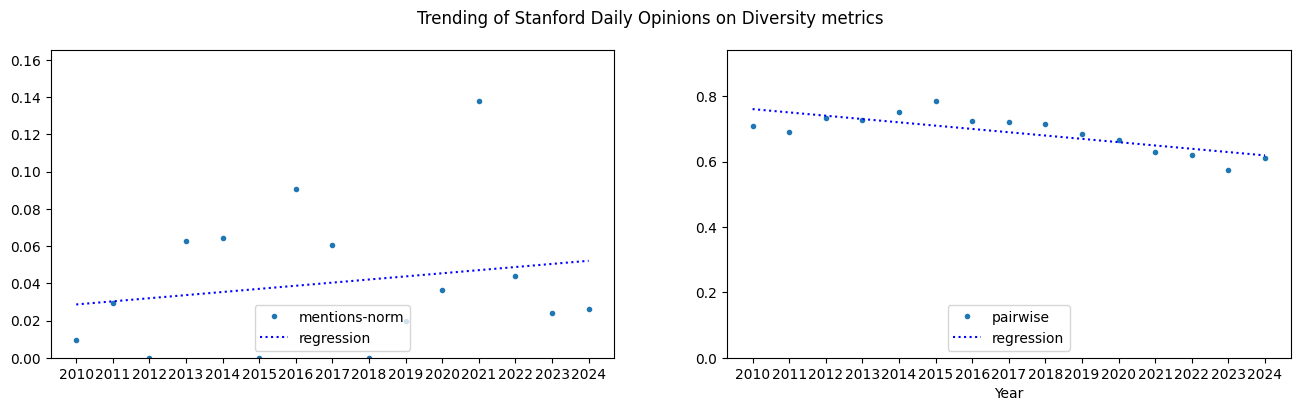

In [52]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Stanford Daily Opinions on Diversity metrics")
plt.show()